# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition using decision tree models.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [1]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
greeks = pd.read_csv(f'{path}/greeks.csv', low_memory=False)
df_train

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


We're interested in identifying the type of positive diagnosis when positive. This is in greeks.Alpha. We merge the greeks df and drop all the columns apart from Alpha.

In [5]:
df_merged = pd.merge(df_train, greeks, on="Id", how="left").drop(columns=["Beta", "Gamma", "Delta", "Epsilon"])
df_train.shape, df_merged.shape

((617, 58), (617, 59))

In [6]:
df_merged.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha'],
      dtype='object')

We can now examine the data.

In [7]:
df_merged.describe(include='all')

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha
count,617,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617
unique,617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,000ff2bfdfe9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,509
mean,NaN,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,...,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041,NaN
std,NaN,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,...,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310,NaN
min,NaN,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,...,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000,NaN
25%,NaN,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,...,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000,NaN
50%,NaN,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,...,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000,NaN
75%,NaN,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,...,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000,NaN


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

We also plot for the type of age-related condition where it is present, using the `Alpha` column from greeks.

<Axes: ylabel='count'>

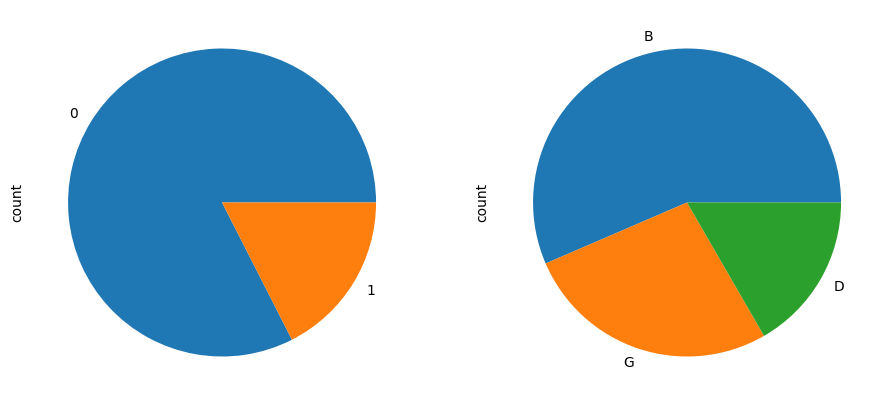

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
df_merged.Class.value_counts().plot(kind="pie", ax=ax1)
df_merged.Alpha[df_merged.Alpha != "A"].value_counts().plot(kind="pie", ax=ax2)

We also check for null values

In [9]:
df_nulls = df_merged.isna().sum()
df_nulls[df_nulls > 0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll do some simple processing. We'll replace the categorical columns `EJ` and `Id` with numeric codes representing their levels.

In [11]:
def process_data(df):
    df["EJ"] = pd.Categorical(df.EJ).codes
    df["Id"] = pd.Categorical(df.Id).codes

    
process_data(df_merged)
process_data(df_test)

In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    int16  
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We need to convert the `Alpha` column to numerical categories. It should be 0, when class is 0, because Alpha is A when Class is negative. Otherwise, it can take unique values for B, D and G. This will be useful for multi-class classification.

In [13]:
alpha_categories = ["A", "B", "D", "G"]
df_merged["Alpha"] = pd.Categorical(df_merged.Alpha, categories=alpha_categories, ordered=True).codes
df_merged

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha
0,0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,1
1,1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,0
2,2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0
3,3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0
4,4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0,0
613,613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0,0
614,614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0,0
615,615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0,0


We can confirm the high correlation between `Class` and `Alpha`.

In [14]:
corr = df_merged[["Class", "Alpha"]].corr()
corr

,Class,Alpha
Class,1.000000,0.873254
Alpha,0.873254,1.000000


# Modeling

Because of the small dataset size, we'll use stratified K-fold for our train/test splits. 

The competition uses the balanced log loss metric which is explained more [here][0]. For our purposes, we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [15]:
from sklearn.metrics import log_loss

def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

For each fold, we train and validate a model and collect the metrics. We'll use `Alpha` as the dependent column for training, so the models will be multi-class classifiers. However, for the final submissions, we'll process the predictions into a binary class predictions of class 0 and class 1.

In [16]:
ycol = "Alpha"
xcols = [c for c in df_merged.columns if not c in ["Id", "Class", ycol]]

def x_y(df):
    y = df[ycol]
    x = df[xcols]
    return x, y

In [17]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier


def get_folds(k_fold, index, y):
    return (splits for splits in k_fold.split(index, y))

def multi_to_binary(multiclass_probs):
    class0_probs = multiclass_probs[:,0]
    return np.array([(prob, 1 - prob) for prob in class0_probs])

def evaluate_gb_model(df, train_ids, val_ids):
    train_xy, valid_xy = df.iloc[train_ids], df.iloc[val_ids]
    
    train_x, train_y = x_y(train_xy)
    val_x, val_y = x_y(valid_xy)
        
    gb = HistGradientBoostingClassifier(class_weight='balanced')
    gb.fit(train_x, train_y) 
    
    accuracy = gb.score(val_x, val_y)
    
    multiclass_probs = gb.predict_proba(val_x)
    binary_probs = multi_to_binary(multiclass_probs)
    
    class1_probs = binary_probs[:,1]
    val_binary = (val_y > 0).astype(int)
       
    logloss = balanced_log_loss(val_binary, class1_probs)

    return gb, logloss, accuracy

In [18]:
#s_kfold = StratifiedKFold(n_splits=5, shuffle=False)
rs_kfold = RepeatedStratifiedKFold(n_repeats=10, n_splits=10)

folds = get_folds(rs_kfold, df_merged.index, df_merged.Alpha)

gb_ensemble, loglosses, accuracies = [], [], []

for i, (x_split, y_split) in enumerate(folds):
    print(f"fold: {i}.. ", end="")
    model, logloss, accuracy = evaluate_gb_model(df_merged, x_split, y_split)
    gb_ensemble.append(model)
    loglosses.append(logloss)
    accuracies.append(accuracy)
np.mean(accuracies), np.mean(loglosses)

fold: 0.. fold: 1.. fold: 2.. fold: 3.. fold: 4.. fold: 5.. fold: 6.. fold: 7.. fold: 8.. fold: 9.. fold: 10.. fold: 11.. fold: 12.. fold: 13.. fold: 14.. fold: 15.. fold: 16.. fold: 17.. fold: 18.. fold: 19.. fold: 20.. fold: 21.. fold: 22.. fold: 23.. fold: 24.. fold: 25.. fold: 26.. fold: 27.. fold: 28.. fold: 29.. fold: 30.. fold: 31.. fold: 32.. fold: 33.. fold: 34.. fold: 35.. fold: 36.. fold: 37.. fold: 38.. fold: 39.. fold: 40.. fold: 41.. fold: 42.. fold: 43.. fold: 44.. fold: 45.. fold: 46.. fold: 47.. fold: 48.. fold: 49.. fold: 50.. fold: 51.. fold: 52.. fold: 53.. fold: 54.. fold: 55.. fold: 56.. fold: 57.. fold: 58.. fold: 59.. fold: 60.. fold: 61.. fold: 62.. fold: 63.. fold: 64.. fold: 65.. fold: 66.. fold: 67.. fold: 68.. fold: 69.. fold: 70.. fold: 71.. fold: 72.. fold: 73.. fold: 74.. fold: 75.. fold: 76.. fold: 77.. fold: 78.. fold: 79.. fold: 80.. fold: 81.. fold: 82.. fold: 83.. fold: 84.. fold: 85.. fold: 86.. fold: 87.. fold: 88.. fold: 89.. fold: 90.. fold: 91.

(0.9214198836594395, 0.5829575420420173)


# Submission

We'll get predictions from the ensemble by averaging all the predictions from the individual models

In [19]:
final_preds = []
for gb in gb_ensemble:
    multiclass_probs = gb.predict_proba(df_test[xcols])
    binary_probs = multi_to_binary(multiclass_probs)
    final_preds.append(binary_probs)
avg_preds = np.stack(final_preds).mean(axis=0)
avg_preds

array([[9.99031745e-01, 9.68255479e-04],
       [9.99031745e-01, 9.68255479e-04],
       [9.99031745e-01, 9.68255479e-04],
       [9.99031745e-01, 9.68255479e-04],
       [9.99031745e-01, 9.68255479e-04]])

In [20]:
submit=True
if is_kaggle and submit:

    df_submission = pd.read_csv(f"{path}/sample_submission.csv")
    df_submission[["class_0", "class_1"]] = avg_preds
    df_submission.to_csv("submission.csv", index=False)